<a href="https://colab.research.google.com/github/Andrea-1704/Pytorch_Geometric_tutorial/blob/main/train_model_baseline_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0
# !pip uninstall -y pyg_lib torch  # Uninstall current versions
# !pip install torch==2.6.0  # Reinstall your desired PyTorch version
# !pip install --no-cache-dir git+https://github.com/pyg-team/pyg-lib.git # Install pyg-lib; --no-cache-dir ensures a fresh install

New libraries to run on colab:

In [2]:
# !pip install torch==2.6.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.6.0+cu118.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0

In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [4]:
import os
import torch
import relbench
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import math
from tqdm import tqdm
import torch_geometric
import torch_frame
from torch_geometric.seed import seed_everything
from relbench.modeling.utils import get_stype_proposal
from collections import defaultdict
import requests
from io import StringIO
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.graph import make_pkey_fkey_graph
from torch.nn import BCEWithLogitsLoss
import copy
from typing import Any, Dict, List
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from relbench.modeling.graph import get_node_train_table_input, make_pkey_fkey_graph
from torch_geometric.loader import NeighborLoader
import pyg_lib
from sklearn.metrics import mean_squared_error
#per lo scheduler
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import networkx as nx
#import os


# Dataset and task creation

In [5]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train")
val_table = task.get_table("val")
test_table = task.get_table("test")

out_channels = 1
# one because we are estimating one single value.
loss_fn = L1Loss()
# this is the mae loss and is used when have regressions tasks.
tune_metric = "mae"
higher_is_better = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
root_dir = "./data"

db = dataset.get_db()
col_to_stype_dict = get_stype_proposal(db)
#this is used to get the stype of the columns

cuda
Loading Database object from /root/.cache/relbench/rel-f1/db...
Done in 0.13 seconds.


# Embedder

In [6]:
# import torch
# from typing import List, Optional
# from sentence_transformers import SentenceTransformer
# from torch import Tensor


# class GloveTextEmbedding:
#     def __init__(self, device: Optional[torch.device
#                                        ] = None):
#         self.model = SentenceTransformer(
#             "sentence-transformers/average_word_embeddings_glove.6B.300d",
#             device=device,
#         )

#     def __call__(self, sentences: List[str]) -> Tensor:
#         return torch.from_numpy(self.model.encode(sentences))


class LightweightGloveEmbedder:
    def __init__(self, device=None):
        self.device = device
        self.embeddings = defaultdict(lambda: np.zeros(300))
        self._load_embeddings()

    def _load_embeddings(self):
        try:
            #(senza bisogno di estrarre zip
            url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.300d.txt"
            response = requests.get(url)
            response.raise_for_status()

            for line in StringIO(response.text):
                parts = line.split()
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)
                self.embeddings[word] = vector
        except Exception as e:
            print(f"Warning: Couldn't load GloVe embeddings ({str(e)}). Using zero vectors.")

    def __call__(self, sentences):
        results = []
        for text in sentences:
            words = text.lower().split()
            vectors = [self.embeddings[w] for w in words if w in self.embeddings]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                avg_vector = np.zeros(300)
            results.append(avg_vector)

        tensor = torch.tensor(np.array(results), dtype=torch.float32)
        return tensor.to(self.device) if self.device else tensor

In [7]:
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=LightweightGloveEmbedder(device=device), batch_size=256
)

data, col_stats_dict = make_pkey_fkey_graph(
    #Solution if not working: !pip install --upgrade torch torchvision transformers
    db,
    col_to_stype_dict=col_to_stype_dict,  # speficied column types
    text_embedder_cfg=text_embedder_cfg,  # our chosen text encoder
    cache_dir=os.path.join(
        root_dir, f"rel-f1_materialized_cache"
    ),  # store materialized graph for convenience
)# create a graph how relbench requires.

/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-pac

In [8]:
loader_dict = {}

for split, table in [
    ("train", train_table),
    ("val", val_table),
    ("test", test_table),
]:
    table_input = get_node_train_table_input(
        table=table,
        task=task,
    )#notice that table_input is an object with three elements: nodes, time and transform.
    #nodes contains the input nodes
    #time contains the time for each node
    #transform is the tranformation to be applied to nodes
    entity_table = table_input.nodes[0]
    #we need to populate the loader_dict with three elements: "train", "val", and "test".
    loader_dict[split] = NeighborLoader(
        data,
        num_neighbors=[
            128 for i in range(2)
        ],  # we sample subgraphs of depth 2, 128 neighbors per node.
        time_attr="time",
        input_nodes=table_input.nodes,
        input_time=table_input.time,
        transform=table_input.transform,
        batch_size=512,
        temporal_strategy="uniform",
        shuffle=split == "train",
        num_workers=0,
        persistent_workers=False,
    )#this is the loader for grapg

# Model

## graphormer layer

In [9]:
_spatial_bias_cache = None
_node_offset_cache = None
from collections import defaultdict


def compute_spatial_bias(edge_index_dict, x_dict):
    global _spatial_bias_cache, _node_offset_cache
    if _spatial_bias_cache is not None:
        return _spatial_bias_cache, _node_offset_cache
    #creiamo un grafo diretto con Networkx
    G = nx.DiGraph()

    node_offset = {}
    curr_offset = 0

    #aggiungiamo i nodi con offset per mantenere indici globali univoci
    for node_type, x in x_dict.items():
        node_offset[node_type] = curr_offset
        for i in range(x.size(0)):
            G.add_node(curr_offset + i, type=node_type)
        curr_offset += x.size(0)

    #Aggiungiamo gli archi con offset
    for (src_type, _, dst_type), edge_index in edge_index_dict.items():
        src_offset = node_offset[src_type]
        dst_offset = node_offset[dst_type]
        src, dst = edge_index
        for s, d in zip(src.tolist(), dst.tolist()):
            G.add_edge(src_offset + s, dst_offset + d)


    spatial_bias = defaultdict(lambda: -1)



    for node in G.nodes():
        lengths = nx.single_source_dijkstra_path_length(G, node)
        for target, dist in lengths.items():
            spatial_bias[(node, target)] = dist
        #quelli non raggiungibili li lasciamo con default value, ovvero -1

    _spatial_bias_cache = spatial_bias
    _node_offset_cache = node_offset

    return spatial_bias, node_offset

In [10]:
import torch
from torch import nn
from torch_geometric.nn import Linear
from torch_geometric.utils import softmax
from torch_geometric.utils import degree
from collections import defaultdict

class HeteroGraphormerLayerComplete(nn.Module):
    def __init__(self, channels, edge_types, device, num_heads=4, dropout=0.1):
        super().__init__()
        self.device = device
        self.num_heads = num_heads
        self.channels = channels
        self.head_dim = channels // num_heads

        assert self.channels % num_heads == 0, "channels must be divisible by num_heads"

        self.q_lin = Linear(channels, channels)
        self.k_lin = Linear(channels, channels)
        self.v_lin = Linear(channels, channels)
        self.out_lin = Linear(channels, channels)

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(channels)

        self.edge_type_bias = nn.ParameterDict({
            "__".join(edge_type): nn.Parameter(torch.randn(1))
            for edge_type in edge_types
        })

    def compute_total_degrees(self, x_dict, edge_index_dict):
        device = self.device
        in_deg = defaultdict(lambda: torch.zeros(0, device=device))
        out_deg = defaultdict(lambda: torch.zeros(0, device=device))
        for edge_type, edge_index in edge_index_dict.items():
            src_type, _, dst_type = edge_type
            src = edge_index[0]
            dst = edge_index[1]

            num_src = x_dict[src_type].size(0)
            num_dst = x_dict[dst_type].size(0)

            if out_deg[src_type].numel() == 0:
                out_deg[src_type] = torch.zeros(num_src, device=device)
            if in_deg[dst_type].numel() == 0:
                in_deg[dst_type] = torch.zeros(num_dst, device=device)

            out_deg[src_type] += degree(src, num_nodes=num_src)
            in_deg[dst_type]  += degree(dst, num_nodes=num_dst)

        total_deg = {
            node_type: in_deg[node_type] + out_deg[node_type]
            for node_type in x_dict
        }

        return total_deg

    def forward(self, x_dict, edge_index_dict):
        self.spatial_bias, self.node_offset = compute_spatial_bias(edge_index_dict, x_dict)

        out_dict = {k: torch.zeros_like(v) for k, v in x_dict.items()}
        for edge_type, edge_index in edge_index_dict.items():
            src_type, _, dst_type = edge_type
            x_src, x_dst = x_dict[src_type], x_dict[dst_type]

            #src, dst = edge_index
            src = edge_index[0]
            dst = edge_index[1]

            Q = self.q_lin(x_dst).view(-1, self.num_heads, self.head_dim)
            K = self.k_lin(x_src).view(-1, self.num_heads, self.head_dim)
            V = self.v_lin(x_src).view(-1, self.num_heads, self.head_dim)

            attn_scores = (Q[dst] * K[src]).sum(dim=-1) / self.head_dim**0.5
            src_offset = self.node_offset[src_type]
            dst_offset = self.node_offset[dst_type]

            spatial_bias_vals = []
            for s, d in zip(src.tolist(), dst.tolist()):
                global_s = src_offset + s
                global_d = dst_offset + d
                dist = self.spatial_bias.get((global_d, global_s), -1.0)
                spatial_bias_vals.append(dist)

            spatial_bias_tensor = torch.tensor(spatial_bias_vals, dtype=torch.float, device=self.device)
            attn_scores = attn_scores + spatial_bias_tensor.unsqueeze(-1)

            bias_name = "__".join(edge_type)
            attn_scores = attn_scores + self.edge_type_bias[bias_name]

            attn_weights = softmax(attn_scores, dst)
            attn_weights = self.dropout(attn_weights)

            out = V[src] * attn_weights.unsqueeze(-1)
            out = out.view(-1, self.channels)

            out_dict[dst_type].index_add_(0, dst, out)

        total_deg = self.compute_total_degrees(x_dict, edge_index_dict)

        for node_type in out_dict:
            # Assicurati che total_deg[node_type] sia della forma corretta (num_nodes, 1)
            degree_embed = total_deg[node_type].view(-1, 1)                                                                                  # Assicurati che sia una colonna
            degree_embed = degree_embed.expand(-1, self.channels)                                                                            # Espandi lungo la dimensione dei canali

            # Somma l'embedding con la degree centrality
            out_dict[node_type] = out_dict[node_type] + degree_embed

        # Normalizzazione finale
        for node_type in out_dict:
            out_dict[node_type] = self.norm(out_dict[node_type] + x_dict[node_type])

        return out_dict


## HeteroGraphormer

In [11]:
class HeteroGraphormer(torch.nn.Module):
    def __init__(self, node_types, edge_types, channels, num_layers=2):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            HeteroGraphormerLayerComplete(channels, edge_types, device) for _ in range(num_layers)
        ])

    def forward(self, x_dict, edge_index_dict, *args, **kwargs):
        for layer in self.layers:
            x_dict = layer(x_dict, edge_index_dict)
        return x_dict

    def reset_parameters(self):
        for layer in self.layers:
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()

In [12]:
class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData, #notice that "data2 is the graph we created with function make_pkey_fkey_graph
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        # List of node types to add shallow embeddings to input
        shallow_list: List[NodeType] = [],
        # ID awareness
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )
        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )
        self.gnn = HeteroGraphormer(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,#one, since we are doing regression
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward_for_embedding(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        # Come la forward ma senza usare seed_time
        x_dict = self.encoder(batch.tf_dict)

        # Se c'è l'embedding ID-aware lo aggiungiamo
        if self.id_awareness_emb is not None:
            for node_type in x_dict:
                x_dict[node_type] += self.id_awareness_emb.weight

        if hasattr(batch[entity_table], "time"):  # fallback se vuoi usare il tempo
            rel_time_dict = self.temporal_encoder(
                batch[entity_table].time,  # oppure seed_time se esiste
                batch.time_dict,
                batch.batch_dict,
            )
            for node_type, rel_time in rel_time_dict.items():
                x_dict[node_type] += rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] += embedding(batch[node_type].n_id)

        z_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )

        return z_dict[entity_table]  # restituisce tutti gli embeddings per quel nodo

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        seed_time = batch[entity_table].seed_time
        #takes the timestamp of the nodes for which we want to make predictions
        #not the neighbours, but the nodes we want to make prediction for.
        x_dict = self.encoder(batch.tf_dict)
        #this creates a dictionar for all the nodes: each nodes has its
        #embedding

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )
        #this add the temporal information to the node using the
        #HeteroTemporalEncoder

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time
        #add some other shallow embedder

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,#feature of nodes
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )#apply the gnn

        return self.head(x_dict[entity_table][: seed_time.size(0)])#final prediction

    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        # Add ID-awareness to the root node
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])


model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)

We also need standard train/test loops

# Pre training task
As a pre training task we would now want to implement a task that is correlated to the real task. What we will do is trying to estimate the "**grid**" value out of the trainig records.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# === MODELLO PER PRE-TRAINING SUL GRID ===

class GraphormerPretrainGrid(nn.Module):
    def __init__(self, graphormer_model, embedding_dim, hidden_dim=128):
        super(GraphormerPretrainGrid, self).__init__()
        self.graphormer = graphormer_model
        self.regressor = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  #predice il valore continuo del GRID
        )

    def forward(self, batch, entity_table='results'):
        #estrae embeddings dal modello Graphormer
        embeddings = self.graphormer.forward_for_embedding(batch, entity_table=entity_table)

        if embeddings is None or len(embeddings) == 0:
            return None

        #predice il valore di GRID
        output = self.regressor(embeddings)
        return output.squeeze()  #ottenere un vettore 1D


## pre training function

In [14]:
def pretrain_grid_loop(
    model,
    optimizer,
    loader,
    loss_fn,
    device="cuda",
    entity_table="results"
):
    model.train()
    total_loss = 0.0
    total_count = 0

    for batch in tqdm(loader):
        #print(batch[entity_table].keys())

        batch = batch.to(device)
        optimizer.zero_grad()
        predictions = model(batch, entity_table=entity_table)
        if predictions is None:
            continue

        tf = batch[entity_table].tf

        # Troviamo la chiave numerica
        numerical_key = None
        for key in tf.col_names_dict.keys():
            if "numerical" in str(key):
                numerical_key = key
                break
        assert numerical_key is not None, "Errore: tipo numerico non trovato!"

        # Trova l'indice di 'grid'
        grid_idx = tf.col_names_dict[numerical_key].index('grid')
        all_grid = tf.feat_dict[numerical_key][:, grid_idx]

        # Prendi solo i nodi centrali del batch
        mask = batch[entity_table].batch == 0

        # Costruisci targets
        targets = (all_grid[mask] / 30.0).float().to(device)
        if predictions[mask].numel() == 0 or targets.numel() == 0:
          continue  # Skippa batch vuoto

        # >>>>>> QUI LA CORREZIONE
        loss = loss_fn(predictions[mask], targets)
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            print("Loss contiene NaN!")
            break

        if torch.isinf(loss):
            print("Loss contiene Inf!")
            break

        total_loss += loss.item()
        total_count += 1

    return total_loss / total_count if total_count > 0 else 0.0


### Scheduler

In [15]:
def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2 * progress)))

    return LambdaLR(optimizer, lr_lambda)


Dobbiamo modificare la funzione di training in modo da ricevere correttamente uno scheduler.

In [24]:
def train(model, optimizer, scheduler) -> float:
    model.train()

    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(
            batch,
            task.entity_table,
        )
#        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred = pred.view(-1) if pred.dim() == 2 and pred.size(1) == 1 else pred


        loss = loss_fn(pred.float(), batch[entity_table].y.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)

    return loss_accum / count_accum


@torch.no_grad()
def test(model, loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        #pred = pred.view(-1) if pred.size(1) == 1 else pred
        if pred.dim() == 2 and pred.size(1) == 1:
           pred = pred.view(-1)

        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [17]:
def rmse(true, pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((true - pred)**2)) # Calculate RMSE manually

In [18]:
def custom_evaluate(pred: np.ndarray, target_table, metrics) -> dict:
    """Custom evaluation function to replace task.evaluate."""

    # Extract target values from the target table
    target = target_table.df[task.target_col].to_numpy()

    # Check for length mismatch
    if len(pred) != len(target):
        raise ValueError(
            f"The length of pred and target must be the same (got "
            f"{len(pred)} and {len(target)}, respectively)."
        )

    # Calculate metrics
    results = {}
    for metric_fn in metrics:
        if metric_fn.__name__ == "rmse":  # Handle RMSE specifically
            results["rmse"] = np.sqrt(np.mean((target - pred)**2))
        else:  # Handle other metrics (if any)
            results[metric_fn.__name__] = metric_fn(target, pred)

    return results

In [19]:
def training_function(model, optimizer, epochs):
    state_dict = None
    best_val_metric = -math.inf if higher_is_better else math.inf
    for epoch in range(1, epochs + 1):
        train_loss = train(model, optimizer)
        val_pred = test(model, loader_dict["val"])
        #val_metrics = task.evaluate(val_pred, val_table)
        val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")
        #print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")

        if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
        ):
            best_val_metric = val_metrics[tune_metric]
            state_dict = copy.deepcopy(model.state_dict())


    model.load_state_dict(state_dict)
    val_pred = test(model, loader_dict["val"])
    val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
    print(f"Best Val metrics for parameters {optimizer}, are: {val_metrics}")

# Training

Andiamo a plottare i valori delle metriche durante il training per avere una visione più avanzata su come stia procedendo il processo di training:

In [20]:
def plot_validation_metrics(metric_histories, model_names=None, metric_name="MAE", informationsTitle=""):
    """
    Plotta l'andamento del metric_name per più modelli nel tempo.

    Args:
        metric_histories (list of lists): Lista di liste, ognuna rappresenta i valori di metriche per un modello.
        model_names (list of str): Nomi dei modelli (opzionale).
        metric_name (str): Nome della metrica da visualizzare.
        informationsTitle (str): info aggiungitive da mettere nel titolo (conf generale dei parametri ecc).
    """
    plt.figure(figsize=(9, 5))

    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(metric_histories))]

    for metrics, name in zip(metric_histories, model_names):
        plt.plot(metrics, marker='o', label=f'{name} {metric_name}')

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs for Multiple Models {informationsTitle}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:



model = Model(
                    data=data,
                    col_stats_dict=col_stats_dict,
                    num_layers=1,
                    channels=128,
                    out_channels=1,
                    aggr="sum",
                    norm="batch_norm",
                ).to(device)

#####PRE TRAINING####
embedding_dim = 128
model = GraphormerPretrainGrid(graphormer_model=model, embedding_dim=embedding_dim).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

loss_fn = nn.MSELoss()
table =  train_table.df
epochs = 50
train_losses = []
for epoch in range(epochs):
    loss = pretrain_grid_loop(
        model=model,
        optimizer=optimizer,
        loader=loader_dict["train"],
        loss_fn=loss_fn,
        device=device
    )
    train_losses.append(loss)
    print(f"Epoch {epoch+1}/{epochs} - Pretraining Loss: {loss:.6f}")




100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


Epoch 1/50 - Pretraining Loss: 0.224706


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 2/50 - Pretraining Loss: 0.076539


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


Epoch 3/50 - Pretraining Loss: 0.081271


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch 4/50 - Pretraining Loss: 0.050121


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 5/50 - Pretraining Loss: 0.056752


100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


Epoch 6/50 - Pretraining Loss: 0.055561


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Epoch 7/50 - Pretraining Loss: 0.013576


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


Epoch 8/50 - Pretraining Loss: 0.012018


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


Epoch 9/50 - Pretraining Loss: 0.008822


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Epoch 10/50 - Pretraining Loss: 0.009171


100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


Epoch 11/50 - Pretraining Loss: 0.009387


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 12/50 - Pretraining Loss: 0.013072


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


Epoch 13/50 - Pretraining Loss: 0.026082


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 14/50 - Pretraining Loss: 0.039244


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


Epoch 15/50 - Pretraining Loss: 0.034889


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch 16/50 - Pretraining Loss: 0.016668


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


Epoch 17/50 - Pretraining Loss: 0.020071


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


Epoch 18/50 - Pretraining Loss: 0.009681


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 19/50 - Pretraining Loss: 0.007768


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 20/50 - Pretraining Loss: 0.007454


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Epoch 21/50 - Pretraining Loss: 0.006138


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


Epoch 22/50 - Pretraining Loss: 0.007474


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Epoch 23/50 - Pretraining Loss: 0.012103


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


Epoch 24/50 - Pretraining Loss: 0.010313


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


Epoch 25/50 - Pretraining Loss: 0.008781


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Epoch 26/50 - Pretraining Loss: 0.006527


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


Epoch 27/50 - Pretraining Loss: 0.003290


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


Epoch 28/50 - Pretraining Loss: 0.003844


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


Epoch 29/50 - Pretraining Loss: 0.005461


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 30/50 - Pretraining Loss: 0.007037


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 31/50 - Pretraining Loss: 0.005729


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Epoch 32/50 - Pretraining Loss: 0.003685


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch 33/50 - Pretraining Loss: 0.002941


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Epoch 34/50 - Pretraining Loss: 0.002674


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Epoch 35/50 - Pretraining Loss: 0.002954


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 36/50 - Pretraining Loss: 0.005378


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


Epoch 37/50 - Pretraining Loss: 0.010094


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


Epoch 38/50 - Pretraining Loss: 0.009447


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 39/50 - Pretraining Loss: 0.010884


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


Epoch 40/50 - Pretraining Loss: 0.009141


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


Epoch 41/50 - Pretraining Loss: 0.005266


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Epoch 42/50 - Pretraining Loss: 0.006090


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch 43/50 - Pretraining Loss: 0.004172


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 44/50 - Pretraining Loss: 0.005368


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Epoch 45/50 - Pretraining Loss: 0.004211


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


Epoch 46/50 - Pretraining Loss: 0.003790


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Epoch 47/50 - Pretraining Loss: 0.003754


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


Epoch 48/50 - Pretraining Loss: 0.011727


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch 49/50 - Pretraining Loss: 0.008813


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Epoch 50/50 - Pretraining Loss: 0.008509


  0%|          | 0/15 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

100%|██████████| 15/15 [00:04<00:00,  3.03it/s]


Epoch: 01, Train loss: 153.76482490141345, Val metrics: {'r2': -0.8950842194482898, 'mae': 5.344049803288523, 'rmse': np.float64(6.3821138495123035)}


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch: 02, Train loss: 65.68823378130556, Val metrics: {'r2': -0.9340353907629046, 'mae': 5.167217936162242, 'rmse': np.float64(6.447368574719857)}


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch: 03, Train loss: 49.41835264172408, Val metrics: {'r2': 0.016312783676602827, 'mae': 3.773888968911741, 'rmse': np.float64(4.598104142318502)}


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch: 04, Train loss: 42.755318699883695, Val metrics: {'r2': 0.20979012994019586, 'mae': 3.318544458275886, 'rmse': np.float64(4.121179345644733)}


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Epoch: 05, Train loss: 38.97677477897133, Val metrics: {'r2': 0.2160690068257186, 'mae': 3.344431697868393, 'rmse': np.float64(4.104773586676112)}


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


Epoch: 06, Train loss: 37.96216105915757, Val metrics: {'r2': 0.19025258795033384, 'mae': 3.362862693491026, 'rmse': np.float64(4.171815313787828)}


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch: 07, Train loss: 37.19786448435833, Val metrics: {'r2': 0.2217656443061019, 'mae': 3.281184003571311, 'rmse': np.float64(4.089832193419984)}


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


Epoch: 08, Train loss: 36.21781262093609, Val metrics: {'r2': 0.22971819286267414, 'mae': 3.2604556015514103, 'rmse': np.float64(4.068882137731502)}


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch: 09, Train loss: 35.521013180809376, Val metrics: {'r2': 0.2808509953947309, 'mae': 3.158390213603884, 'rmse': np.float64(3.931513139538221)}


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


Epoch: 10, Train loss: 35.43206730756474, Val metrics: {'r2': 0.25449293982408117, 'mae': 3.2274841453205685, 'rmse': np.float64(4.002913173332664)}


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch: 11, Train loss: 35.09024359200059, Val metrics: {'r2': 0.18419611341495645, 'mae': 3.409950949274546, 'rmse': np.float64(4.187387715601239)}


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch: 12, Train loss: 35.08271061979043, Val metrics: {'r2': 0.22952413312935627, 'mae': 3.2736837029695987, 'rmse': np.float64(4.069394649158782)}


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch: 13, Train loss: 34.64559677535538, Val metrics: {'r2': 0.2732541495605133, 'mae': 3.167787153145912, 'rmse': np.float64(3.9522241719071785)}


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Epoch: 14, Train loss: 34.497343140897314, Val metrics: {'r2': 0.24621663527723592, 'mae': 3.229521861550962, 'rmse': np.float64(4.025071171675374)}


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch: 15, Train loss: 34.6439990050422, Val metrics: {'r2': 0.22553512243539386, 'mae': 3.2681564956007594, 'rmse': np.float64(4.079915356524933)}


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch: 16, Train loss: 34.20005244330945, Val metrics: {'r2': 0.245865665675023, 'mae': 3.2205230699512426, 'rmse': np.float64(4.026008120733236)}


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


Epoch: 17, Train loss: 33.867303352555574, Val metrics: {'r2': 0.25945225187783927, 'mae': 3.190631388980863, 'rmse': np.float64(3.989576733225038)}


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


Epoch: 18, Train loss: 33.65388621948684, Val metrics: {'r2': 0.2670989186180355, 'mae': 3.189810723627737, 'rmse': np.float64(3.9689257189046727)}


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Epoch: 19, Train loss: 33.547575137958454, Val metrics: {'r2': 0.23376912746265766, 'mae': 3.295276414543769, 'rmse': np.float64(4.058168848579631)}


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


Epoch: 20, Train loss: 33.27948648536444, Val metrics: {'r2': 0.21422801835631833, 'mae': 3.3287302703322292, 'rmse': np.float64(4.109590598298994)}


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


Epoch: 21, Train loss: 33.39979883048353, Val metrics: {'r2': 0.22834557614151696, 'mae': 3.2902825984942097, 'rmse': np.float64(4.072505830867563)}


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


Epoch: 22, Train loss: 33.22059830809286, Val metrics: {'r2': 0.23649117699113176, 'mae': 3.2513046313064766, 'rmse': np.float64(4.050954074795835)}


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch: 23, Train loss: 33.04540200273767, Val metrics: {'r2': 0.2252221465860712, 'mae': 3.27208607953313, 'rmse': np.float64(4.080739658588571)}


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


Epoch: 24, Train loss: 32.97396513799301, Val metrics: {'r2': 0.21055150521787547, 'mae': 3.30711909926726, 'rmse': np.float64(4.1191934679881514)}


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch: 25, Train loss: 32.82144456272491, Val metrics: {'r2': 0.2132485355693875, 'mae': 3.310052220695562, 'rmse': np.float64(4.112151150042208)}


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch: 26, Train loss: 32.676979195459026, Val metrics: {'r2': 0.21362503862535676, 'mae': 3.3003385030992365, 'rmse': np.float64(4.111167089117161)}


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


Epoch: 27, Train loss: 32.61190042683826, Val metrics: {'r2': 0.20896130900803633, 'mae': 3.311277261860146, 'rmse': np.float64(4.123340052977794)}


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


Epoch: 28, Train loss: 32.52021255247484, Val metrics: {'r2': 0.20655811087074982, 'mae': 3.310582998233711, 'rmse': np.float64(4.129598715510703)}


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


Epoch: 29, Train loss: 32.655457615772384, Val metrics: {'r2': 0.20377125854542155, 'mae': 3.3234168371838892, 'rmse': np.float64(4.136844673962563)}


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


Epoch: 30, Train loss: 32.53728518427802, Val metrics: {'r2': 0.2069998512094916, 'mae': 3.3151365217082724, 'rmse': np.float64(4.12844900036862)}
Best Val metrics: {'r2': 0.2802804306750709, 'mae': 3.159278554540518, 'rmse': np.float64(3.933072439436699)}
Best test metrics: {'r2': 0.16420793723282145, 'mae': 3.852445197900136, 'rmse': np.float64(4.763421110870863)}


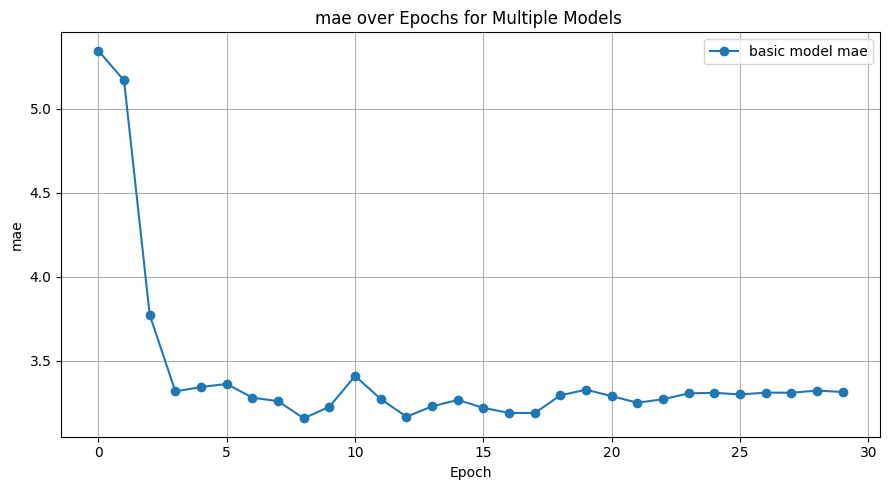

In [25]:
#####TRAINING####
epochs = 30
total_steps = epochs * len(loader_dict["train"])
warmup_steps = int(0.1 * total_steps)  # 10% warmup
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
state_dict = None
best_val_metric = -math.inf if higher_is_better else math.inf

#per mantenere la storia dei MAE nel tempo:
val_metr_history = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, scheduler)
    val_pred = test(model, loader_dict["val"])
    #val_metrics = task.evaluate(val_pred, val_table)
    val_metrics = custom_evaluate(val_pred, val_table, task.metrics)

    val_metr_history.append(val_metrics[tune_metric])

    print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())


model.load_state_dict(state_dict)
val_pred = test(model, loader_dict["val"])
val_metrics = custom_evaluate(val_pred, val_table, task.metrics)
print(f"Best Val metrics: {val_metrics}")

test_table = task.get_table("test", mask_input_cols=False)
test_pred = test(model,loader_dict["test"])
test_metrics = custom_evaluate(test_pred, test_table, task.metrics)
print(f"Best test metrics: {test_metrics}")

plot_validation_metrics([val_metr_history], ["basic model"],  metric_name=tune_metric)
